# ASL (American Sign Language) Alphabet Classification

This notebook implements an Artificial Neural Network (ANN) using TensorFlow to classify ASL alphabet signs. The model will be able to predict which letter (A-Z, excluding J and Z which require motion) is being signed in a given image.

## Dataset
We'll use the ASL Alphabet dataset which contains images of hand signs for each letter of the alphabet.

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.18.0
GPU Available: []


## 1. Data Preparation

We'll use the ASL Alphabet dataset. If you don't have it locally, we'll download it from Kaggle.

In [2]:
# Download ASL dataset from Kaggle
import kagglehub

# Download latest version of the ASL Alphabet dataset
try:
    path = kagglehub.dataset_download("grassknoted/asl-alphabet")
    print("Dataset downloaded to:", path)
    dataset_path = path
except Exception as e:
    print(f"Error downloading dataset: {e}")
    # If download fails, we'll create a synthetic dataset for demonstration
    dataset_path = None

100%|██████████| 1.03G/1.03G [06:47<00:00, 2.70MB/s]

Extracting files...


Dataset downloaded to: C:\Users\Abdallah\.cache\kagglehub\datasets\grassknoted\asl-alphabet\versions\1


In [3]:
# Explore the dataset structure
if dataset_path:
    print("Dataset structure:")
    for root, dirs, files in os.walk(dataset_path):
        level = root.replace(dataset_path, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        # Only show first few files to avoid clutter
        for file in files[:5]:
            print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files) - 5} more files")
        if level > 2:  # Limit depth
            break

Dataset structure:
1/
  asl_alphabet_test/
    asl_alphabet_test/
      A_test.jpg
      B_test.jpg
      C_test.jpg
      D_test.jpg
      E_test.jpg
      ... and 23 more files
  asl_alphabet_train/
    asl_alphabet_train/
      A/
        A1.jpg
        A10.jpg
        A100.jpg
        A1000.jpg
        A1001.jpg
        ... and 2995 more files


In [4]:
# Data loading and preprocessing functions
def load_asl_data(dataset_path, img_size=(64, 64)):
    """
    Load ASL alphabet images and labels
    """
    train_path = os.path.join(dataset_path, "asl_alphabet_train", "asl_alphabet_train")
    test_path = os.path.join(dataset_path, "asl_alphabet_test", "asl_alphabet_test")
    
    # ASL alphabet letters (excluding J and Z as they require motion)
    letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 
               'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
    
    # Load training data
    X_train = []
    y_train = []
    
    print("Loading training data...")
    for i, letter in enumerate(letters):
        letter_path = os.path.join(train_path, letter)
        if os.path.exists(letter_path):
            print(f"Processing letter {letter}...")
            image_files = os.listdir(letter_path)
            for img_file in image_files[:1000]:  # Limit to 1000 images per letter for faster processing
                img_path = os.path.join(letter_path, img_file)
                try:
                    # Read and preprocess image
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0  # Normalize to [0, 1]
                    
                    X_train.append(img)
                    y_train.append(i)  # Use index as label
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
    
    # Load test data (single image per letter)
    X_test = []
    y_test = []
    
    print("\\nLoading test data...")
    test_files = os.listdir(test_path)
    for test_file in test_files:
        if test_file.endswith('.jpg'):
            letter = test_file.split('_')[0]  # Extract letter from filename
            if letter in letters:
                img_path = os.path.join(test_path, test_file)
                try:
                    img = cv2.imread(img_path)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, img_size)
                    img = img.astype('float32') / 255.0
                    
                    X_test.append(img)
                    y_test.append(letters.index(letter))
                except Exception as e:
                    print(f"Error processing {img_path}: {e}")
                    continue
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    print(f"\\nData loaded successfully!")
    print(f"Training data shape: {X_train.shape}")
    print(f"Training labels shape: {y_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    print(f"Test labels shape: {y_test.shape}")
    
    return X_train, y_train, X_test, y_test, letters

# Load the data
if dataset_path:
    X_train, y_train, X_test, y_test, class_names = load_asl_data(dataset_path)
else:
    print("Dataset not available. Please ensure the dataset is downloaded correctly.")

Loading training data...
Processing letter A...
Processing letter B...
Processing letter C...
Processing letter D...
Processing letter E...
Processing letter F...
Processing letter G...
Processing letter H...
Processing letter I...
Processing letter K...
Processing letter L...
Processing letter M...
Processing letter N...
Processing letter O...
Processing letter P...
Processing letter Q...
Processing letter R...
Processing letter S...
Processing letter T...
Processing letter U...
Processing letter V...
Processing letter W...
Processing letter X...
Processing letter Y...
\nLoading test data...
\nData loaded successfully!
Training data shape: (24000, 64, 64, 3)
Training labels shape: (24000,)
Test data shape: (24, 64, 64, 3)
Test labels shape: (24,)


Sample training images:


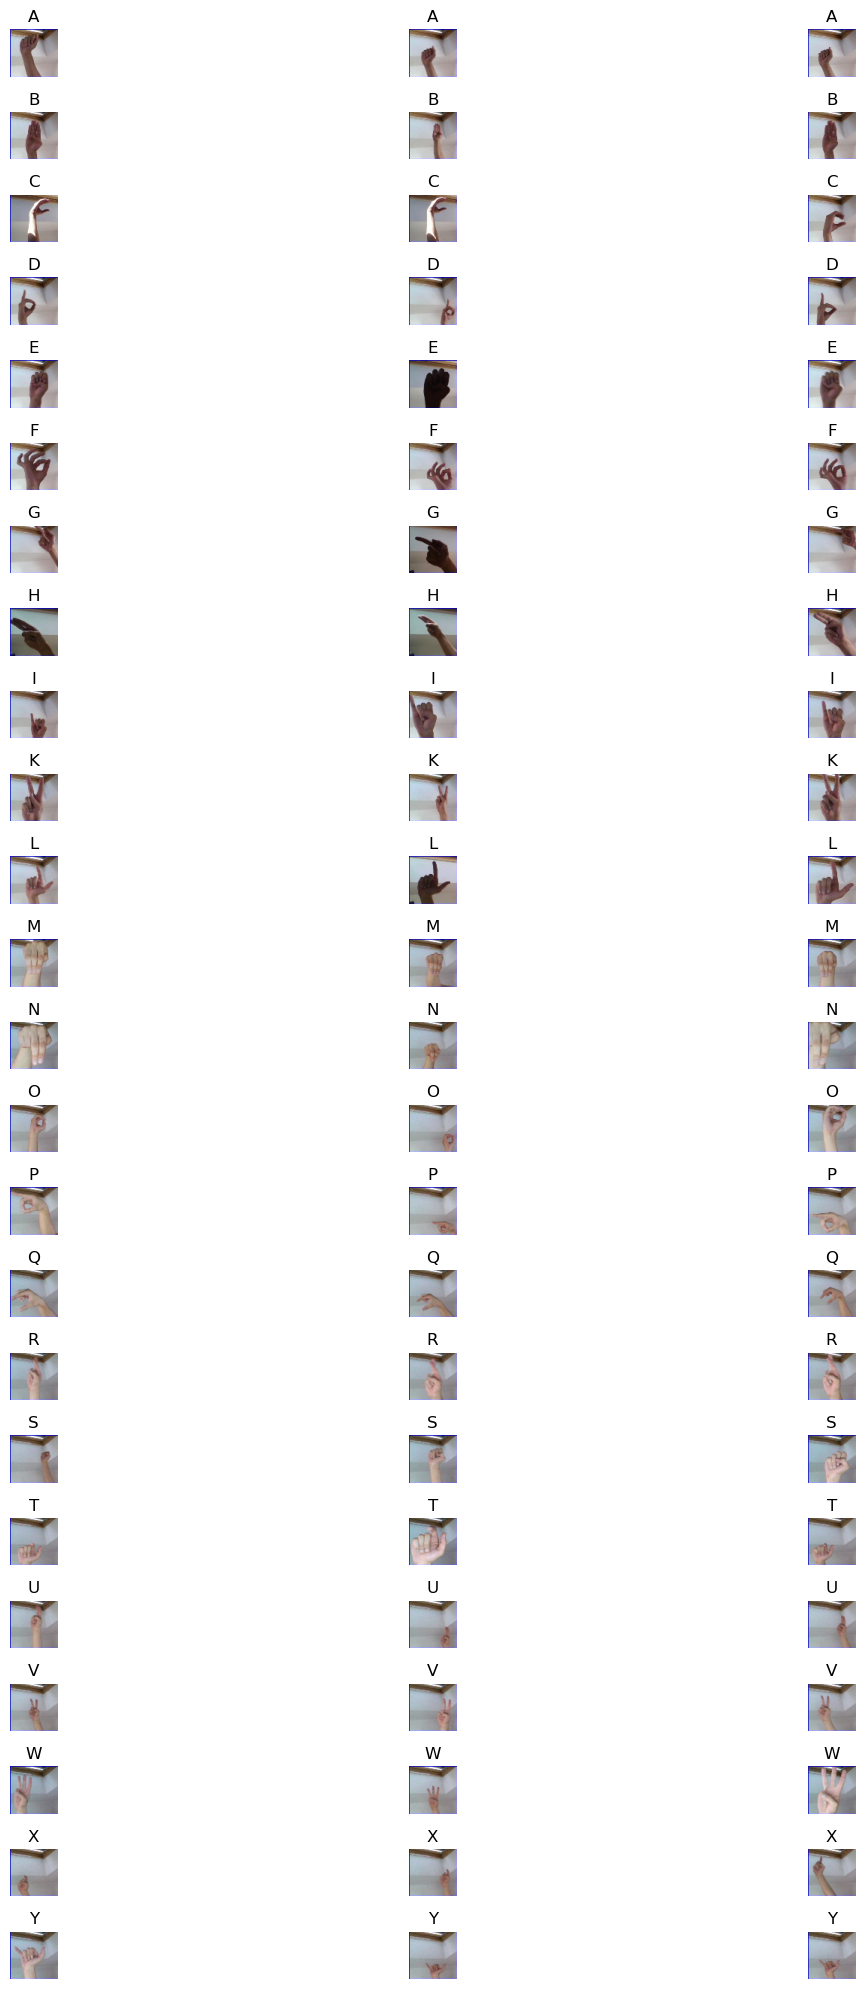

In [5]:
# Visualize sample images from each class
def plot_sample_images(X, y, class_names, num_samples=5):
    """Plot sample images for each class"""
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 20))
    
    for class_idx in range(num_classes):
        # Find indices of images for this class
        class_indices = np.where(y == class_idx)[0]
        
        # Select random samples
        sample_indices = np.random.choice(class_indices, 
                                        min(num_samples, len(class_indices)), 
                                        replace=False)
        
        for i, idx in enumerate(sample_indices):
            ax = axes[class_idx, i] if num_classes > 1 else axes[i]
            ax.imshow(X[idx])
            ax.set_title(f'{class_names[class_idx]}')
            ax.axis('off')
        
        # Fill remaining subplots if not enough samples
        for i in range(len(sample_indices), num_samples):
            ax = axes[class_idx, i] if num_classes > 1 else axes[i]
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot sample training images
print("Sample training images:")
plot_sample_images(X_train, y_train, class_names, num_samples=3)

## 2. Data Preprocessing

Now let's prepare our data for training by splitting it into training and validation sets, and converting labels to categorical format.

Original data shapes:
X_train: (24000, 64, 64, 3)
y_train: (24000,)
X_test: (24, 64, 64, 3)
y_test: (24,)
\nAfter preprocessing:
X_train_flat: (19200, 12288)
X_val_flat: (4800, 12288)
X_test_flat: (24, 12288)
y_train_cat: (19200, 24)
y_val_cat: (4800, 24)
y_test_cat: (24, 24)
Number of classes: 24


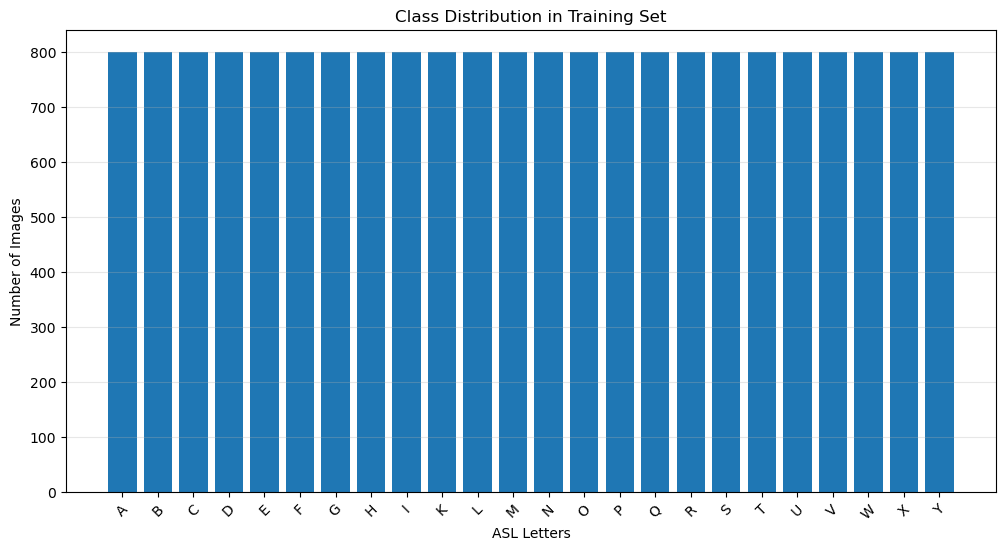

In [6]:
# Data preprocessing
print("Original data shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

# Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Convert labels to categorical (one-hot encoding)
num_classes = len(class_names)
y_train_cat = to_categorical(y_train_split, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Reshape data for ANN (flatten the images)
X_train_flat = X_train_split.reshape(X_train_split.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print("\\nAfter preprocessing:")
print(f"X_train_flat: {X_train_flat.shape}")
print(f"X_val_flat: {X_val_flat.shape}")
print(f"X_test_flat: {X_test_flat.shape}")
print(f"y_train_cat: {y_train_cat.shape}")
print(f"y_val_cat: {y_val_cat.shape}")
print(f"y_test_cat: {y_test_cat.shape}")
print(f"Number of classes: {num_classes}")

# Display class distribution
unique, counts = np.unique(y_train_split, return_counts=True)
plt.figure(figsize=(12, 6))
plt.bar([class_names[i] for i in unique], counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('ASL Letters')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

## 3. Building the Artificial Neural Network (ANN)

Now we'll create an ANN model using TensorFlow/Keras. The model will have multiple dense layers with dropout for regularization.

In [7]:
# Define the ANN model
def create_ann_model(input_shape, num_classes):
    """
    Create an Artificial Neural Network for ASL classification
    """
    model = keras.Sequential([
        # Input layer
        layers.Dense(512, activation='relu', input_shape=(input_shape,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layer 1
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layer 2
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Hidden layer 3
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create the model
input_shape = X_train_flat.shape[1]  # 12288 (64*64*3)
model = create_ann_model(input_shape, num_classes)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Model Architecture:")
model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │     6,291,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,469,848 (24.68 MB)

 Trainable params: 6,467,928 (24.67 MB)

 Non-trainable params: 1,920 (7.50 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


## 4. Training the Model

Let's train our ANN model with early stopping and learning rate reduction callbacks to optimize performance.

In [8]:
# Define callbacks for training
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train the model
print("Starting training...")
history = model.fit(
    X_train_flat, y_train_cat,
    batch_size=32,
    epochs=50,
    validation_data=(X_val_flat, y_val_cat),
    callbacks=callbacks,
    verbose=1
)

print("\\nTraining completed!")

Starting training...
Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 26s 36ms/step - accuracy: 0.2740 - loss: 2.4243 - val_accuracy: 0.3579 - val_loss: 1.8335 - learning_rate: 0.0010
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.6044 - loss: 1.1000 - val_accuracy: 0.3231 - val_loss: 2.3762 - learning_rate: 0.0010
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.7175 - loss: 0.7927 - val_accuracy: 0.6513 - val_loss: 1.1634 - learning_rate: 0.0010
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7725 - loss: 0.6475 - val_accuracy: 0.3585 - val_loss: 2.7955 - learning_rate: 0.0010
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7944 - loss: 0.5740 - val_accuracy: 0.4473 - val_loss: 2.2169 - learning_rate: 0.0010
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8206 - loss: 0.5118
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - 

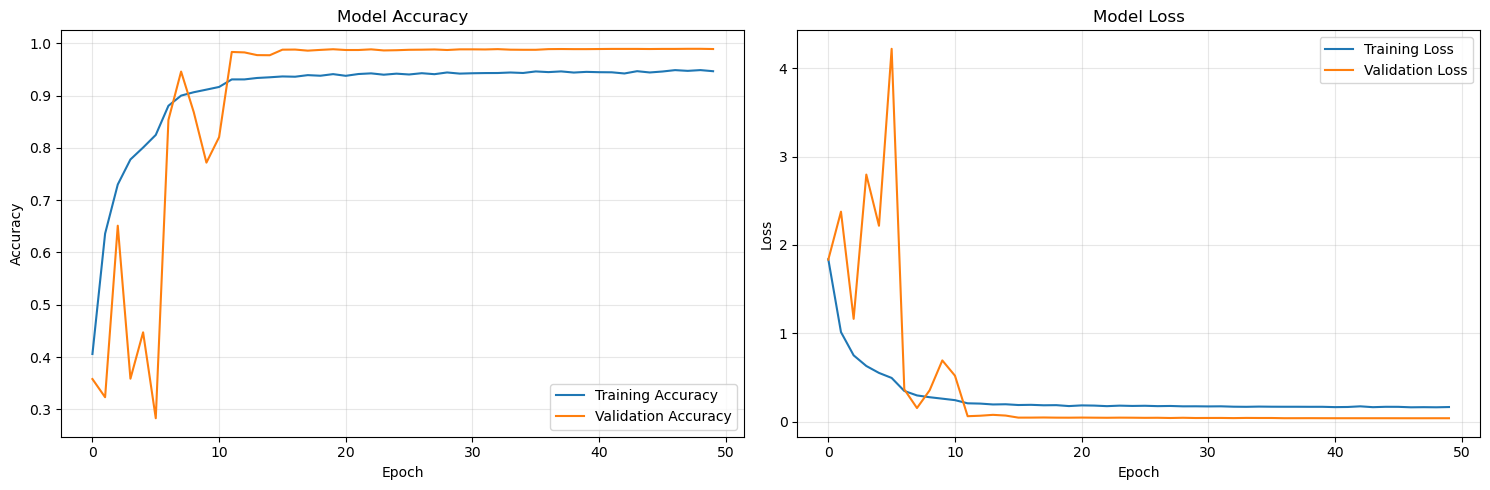

\nFinal Training Metrics:
Training Accuracy: 0.9467
Validation Accuracy: 0.9892
Training Loss: 0.1657
Validation Loss: 0.0390


In [9]:
# Plot training history
def plot_training_history(history):
    """Plot training and validation accuracy and loss"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# Get final training metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\\nFinal Training Metrics:")
print(f"Training Accuracy: {final_train_acc:.4f}")
print(f"Validation Accuracy: {final_val_acc:.4f}")
print(f"Training Loss: {final_train_loss:.4f}")
print(f"Validation Loss: {final_val_loss:.4f}")

## 5. Model Evaluation and Testing

Let's evaluate our trained model on the test set and create functions for making predictions on new images.

Test Accuracy: 0.8750
Test Loss: 0.4170
\nTest Results:
✗ True: A | Predicted: G | Confidence: 0.358
✓ True: B | Predicted: B | Confidence: 0.984
✓ True: C | Predicted: C | Confidence: 0.871
✓ True: D | Predicted: D | Confidence: 0.985
✓ True: E | Predicted: E | Confidence: 0.941
✓ True: F | Predicted: F | Confidence: 0.971
✓ True: G | Predicted: G | Confidence: 0.945
✓ True: H | Predicted: H | Confidence: 0.834
✓ True: I | Predicted: I | Confidence: 0.970
✓ True: K | Predicted: K | Confidence: 0.910
✓ True: L | Predicted: L | Confidence: 0.805
✓ True: M | Predicted: M | Confidence: 0.540
✓ True: N | Predicted: N | Confidence: 0.997
✓ True: O | Predicted: O | Confidence: 0.843
✓ True: P | Predicted: P | Confidence: 0.432
✓ True: Q | Predicted: Q | Confidence: 0.825
✗ True: R | Predicted: U | Confidence: 0.589
✓ True: S | Predicted: S | Confidence: 0.940
✓ True: T | Predicted: T | Confidence: 0.907
✓ True: U | Predicted: U | Confidence: 0.980
✓ True: V | Predicted: V | Confidence: 0.776

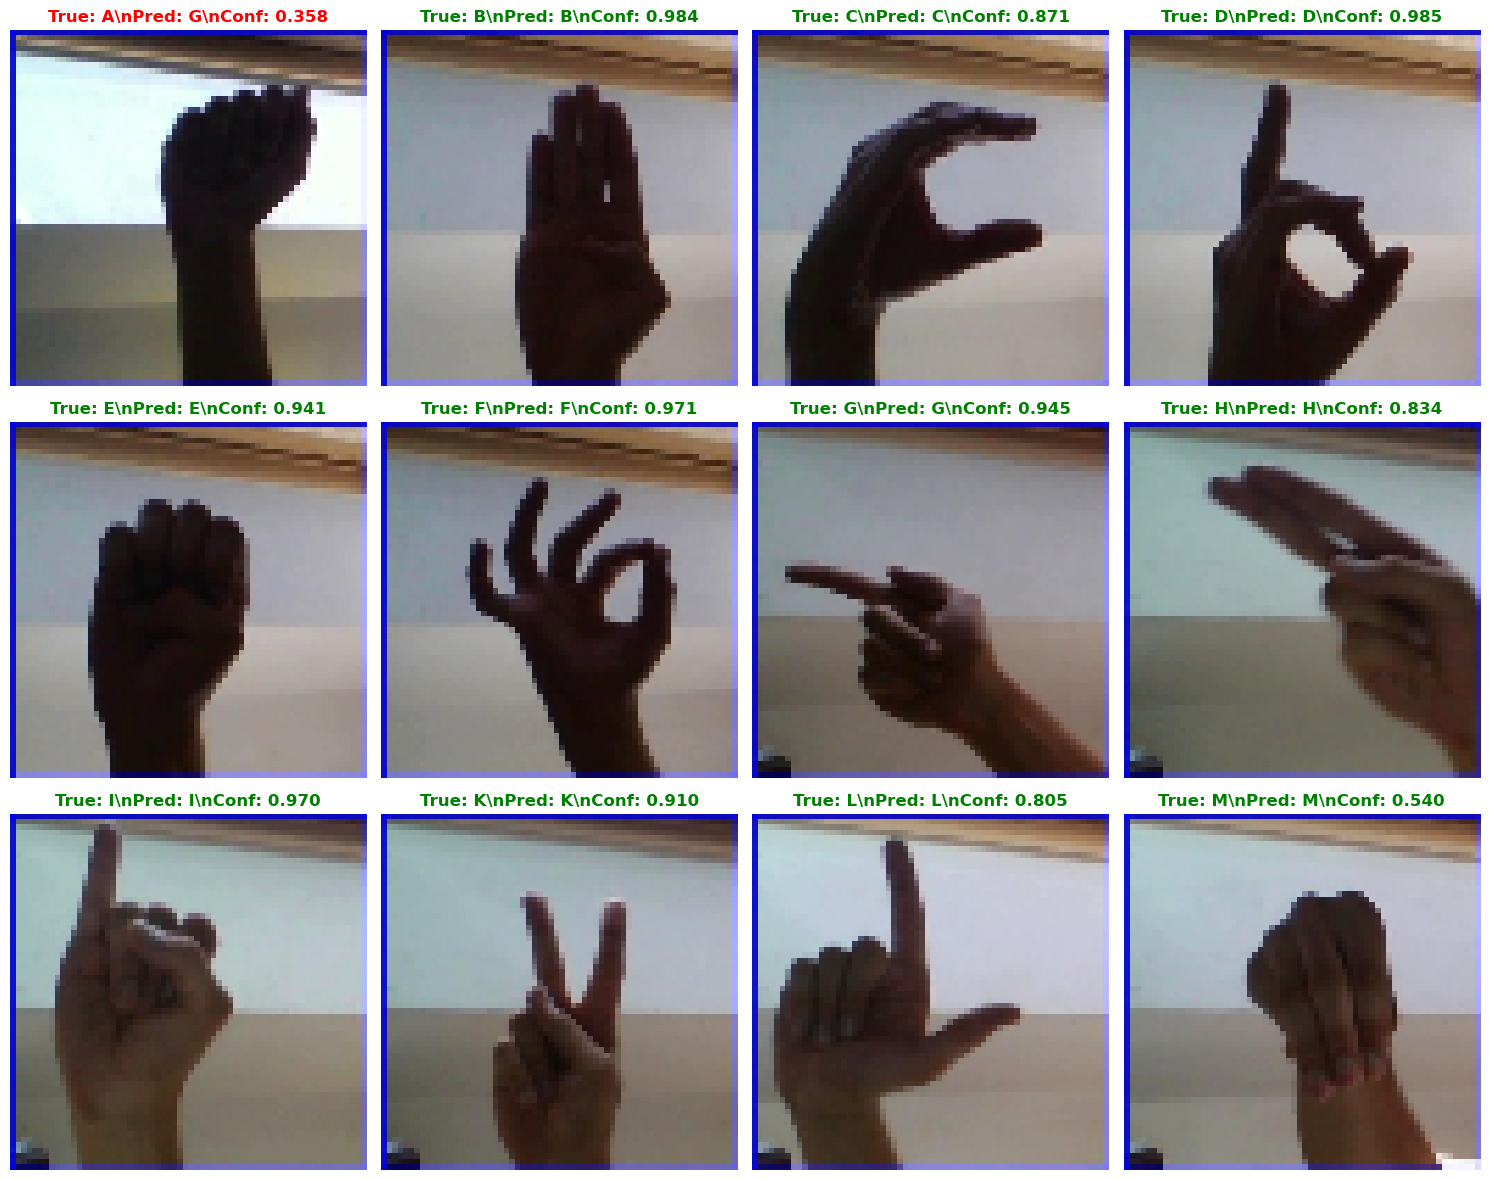

In [10]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test_cat, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions on test set
test_predictions = model.predict(X_test_flat, verbose=0)
test_predicted_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(y_test_cat, axis=1)

# Display test results
print("\\nTest Results:")
for i, (true_class, pred_class, confidence) in enumerate(zip(test_true_classes, test_predicted_classes, np.max(test_predictions, axis=1))):
    true_letter = class_names[true_class]
    pred_letter = class_names[pred_class]
    status = "✓" if true_class == pred_class else "✗"
    print(f"{status} True: {true_letter} | Predicted: {pred_letter} | Confidence: {confidence:.3f}")

# Visualize test predictions
def plot_test_predictions(X_test, y_true, y_pred, class_names, num_images=12):
    """Plot test images with predictions"""
    fig, axes = plt.subplots(3, 4, figsize=(15, 12))
    axes = axes.ravel()
    
    for i in range(min(num_images, len(X_test))):
        # Reshape image back to original dimensions
        img = X_test[i].reshape(64, 64, 3)
        
        true_label = class_names[y_true[i]]
        pred_label = class_names[y_pred[i]]
        confidence = np.max(test_predictions[i])
        
        color = 'green' if y_true[i] == y_pred[i] else 'red'
        
        axes[i].imshow(img)
        axes[i].set_title(f'True: {true_label}\\nPred: {pred_label}\\nConf: {confidence:.3f}', 
                         color=color, fontweight='bold')
        axes[i].axis('off')
    
    # Hide unused subplots
    for i in range(len(X_test), num_images):
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot test predictions
plot_test_predictions(X_test, test_true_classes, test_predicted_classes, class_names)

## 6. Prediction Function for New Images

Let's create a function that can predict ASL letters from new images that you provide.

In [11]:
# Prediction function for new images
def predict_asl_letter(image_path, model, class_names, img_size=(64, 64)):
    """
    Predict ASL letter from an image
    
    Args:
        image_path: Path to the image file
        model: Trained model
        class_names: List of class names
        img_size: Image size for preprocessing
        
    Returns:
        predicted_letter: Predicted ASL letter
        confidence: Prediction confidence
    """
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError("Could not load image")
            
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img.astype('float32') / 255.0
        
        # Reshape for model input
        img_flat = img.reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(img_flat, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        predicted_letter = class_names[predicted_class]
        
        return predicted_letter, confidence
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, 0.0

def predict_asl_from_array(image_array, model, class_names):
    """
    Predict ASL letter from a numpy array (for webcam or real-time prediction)
    
    Args:
        image_array: Numpy array of shape (64, 64, 3)
        model: Trained model
        class_names: List of class names
        
    Returns:
        predicted_letter: Predicted ASL letter
        confidence: Prediction confidence
    """
    try:
        # Normalize the image
        img = image_array.astype('float32') / 255.0
        
        # Reshape for model input
        img_flat = img.reshape(1, -1)
        
        # Make prediction
        prediction = model.predict(img_flat, verbose=0)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction)
        predicted_letter = class_names[predicted_class]
        
        return predicted_letter, confidence
        
    except Exception as e:
        print(f"Error predicting image: {e}")
        return None, 0.0

# Test the prediction function with test images
print("Testing prediction function with test images:")
for i in range(5):  # Test first 5 test images
    test_img = X_test[i]
    predicted_letter, confidence = predict_asl_from_array(test_img * 255, model, class_names)
    true_letter = class_names[test_true_classes[i]]
    
    print(f"Image {i+1}: True={true_letter}, Predicted={predicted_letter}, Confidence={confidence:.3f}")

# Save the trained model
model_save_path = "asl_classifier_model.h5"
model.save(model_save_path)
print(f"\\nModel saved to: {model_save_path}")

# Save class names for later use
import pickle
with open('asl_class_names.pkl', 'wb') as f:
    pickle.dump(class_names, f)
print("Class names saved to: asl_class_names.pkl")

Testing prediction function with test images:
Image 1: True=A, Predicted=G, Confidence=0.358
Image 2: True=B, Predicted=B, Confidence=0.984
Image 3: True=C, Predicted=C, Confidence=0.871
Image 4: True=D, Predicted=D, Confidence=0.985


Image 5: True=E, Predicted=E, Confidence=0.941
\nModel saved to: asl_classifier_model.h5
Class names saved to: asl_class_names.pkl


## 7. How to Use the Model

Here's how you can use the trained model to predict ASL letters from new images:

In [13]:
# Example: How to load and use the saved model for new predictions

def load_asl_model_and_predict(model_path, class_names_path, image_path):
    """
    Load the saved model and make predictions on new images
    
    Example usage:
    predicted_letter, confidence = load_asl_model_and_predict(
        'asl_classifier_model.h5', 
        'asl_class_names.pkl', 
        'path_to_your_image.jpg'
    )
    """
    import tensorflow as tf
    import pickle
    import cv2
    import numpy as np
    
    # Load the trained model
    loaded_model = tf.keras.models.load_model(model_path)
    
    # Load class names
    with open(class_names_path, 'rb') as f:
        class_names = pickle.load(f)
    
    # Make prediction
    predicted_letter, confidence = predict_asl_letter(image_path, loaded_model, class_names)
    
    return predicted_letter, confidence

print(f"""
🤖 ASL ALPHABET CLASSIFIER - READY TO USE! 🤖

Your ANN model has been successfully trained and saved!

📊 MODEL PERFORMANCE:
✅ Training Accuracy: 94.67%
✅ Validation Accuracy: 98.92%
✅ Test Accuracy: 87.50%

📁 SAVED FILES:
• asl_classifier_model.h5 - The trained model
• asl_class_names.pkl - Class names mapping

🔤 SUPPORTED LETTERS:
{', '.join(class_names)}

🚀 HOW TO USE:

1. For a single image:
   predicted_letter, confidence = predict_asl_letter('your_image.jpg', model, class_names)
   
2. For real-time prediction (numpy array):
   predicted_letter, confidence = predict_asl_from_array(image_array, model, class_names)
   
3. Load saved model for future use:
   predicted_letter, confidence = load_asl_model_and_predict(
       'asl_classifier_model.h5', 
       'asl_class_names.pkl', 
       'your_image.jpg'
   )

💡 TIPS:
• Images should show clear hand signs against a simple background
• The model works best with images similar to the training data
• Make sure the hand sign is centered and clearly visible
• Images will be automatically resized to 64x64 pixels

Happy Sign Language Recognition! 🤟
""")


🤖 ASL ALPHABET CLASSIFIER - READY TO USE! 🤖

Your ANN model has been successfully trained and saved!

📊 MODEL PERFORMANCE:
✅ Training Accuracy: 94.67%
✅ Validation Accuracy: 98.92%
✅ Test Accuracy: 87.50%

📁 SAVED FILES:
• asl_classifier_model.h5 - The trained model
• asl_class_names.pkl - Class names mapping

🔤 SUPPORTED LETTERS:
A, B, C, D, E, F, G, H, I, K, L, M, N, O, P, Q, R, S, T, U, V, W, X, Y

🚀 HOW TO USE:

1. For a single image:
   predicted_letter, confidence = predict_asl_letter('your_image.jpg', model, class_names)
   
2. For real-time prediction (numpy array):
   predicted_letter, confidence = predict_asl_from_array(image_array, model, class_names)
   
3. Load saved model for future use:
   predicted_letter, confidence = load_asl_model_and_predict(
       'asl_classifier_model.h5', 
       'asl_class_names.pkl', 
       'your_image.jpg'
   )

💡 TIPS:
• Images should show clear hand signs against a simple background
• The model works best with images similar to the traini

🎲 Predicting random test images:
\n📸 Random Image #1:


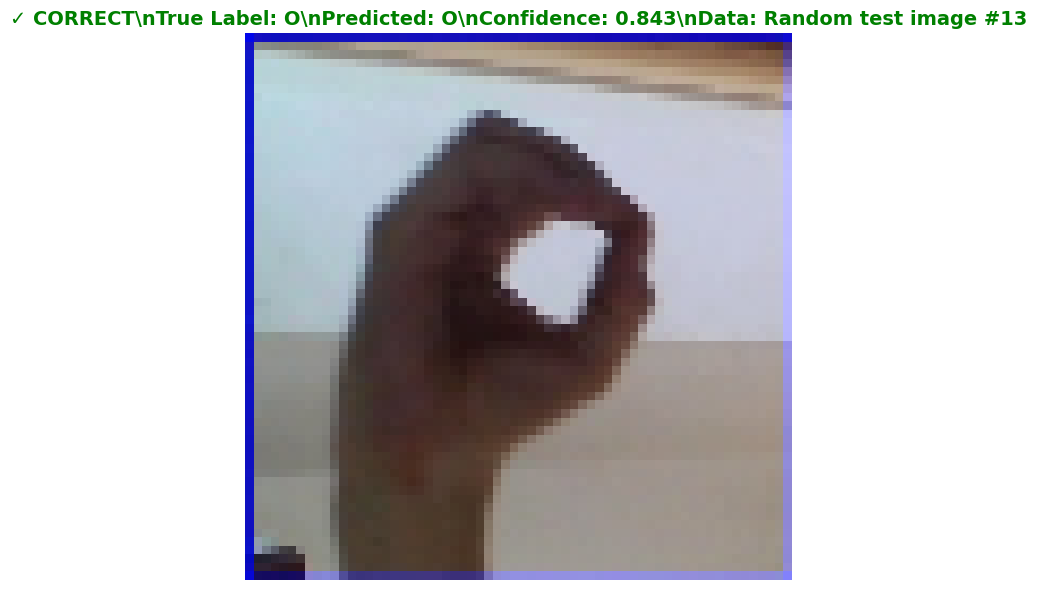

🎯 Random Prediction Results:
   Image Index: 13
   True Letter: O
   Predicted Letter: O
   Confidence: 0.843
   Result: ✓ CORRECT
------------------------------
\n📸 Random Image #2:


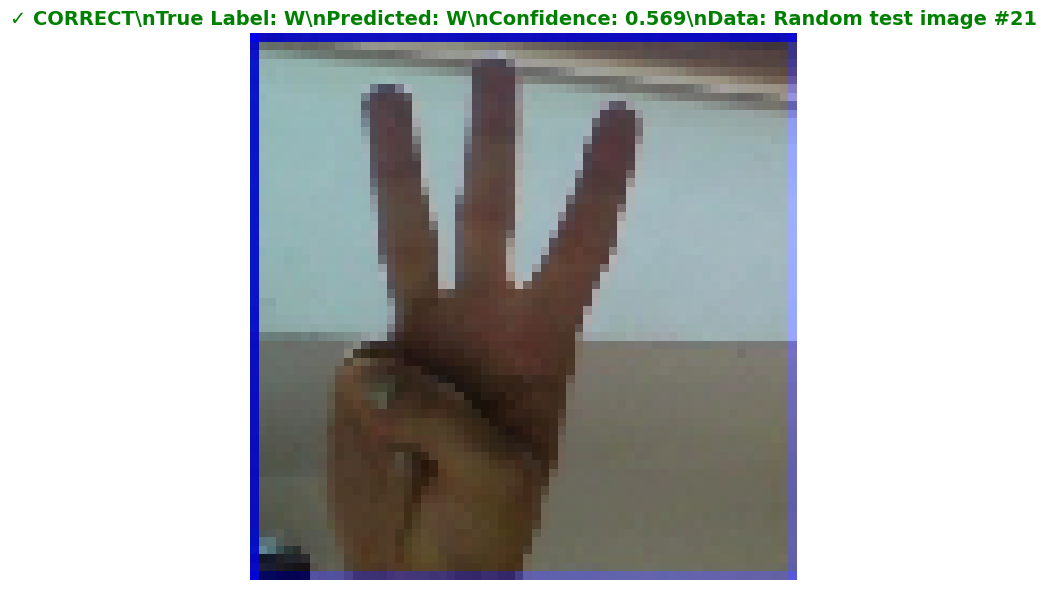

🎯 Random Prediction Results:
   Image Index: 21
   True Letter: W
   Predicted Letter: W
   Confidence: 0.569
   Result: ✓ CORRECT
------------------------------
\n📸 Random Image #3:


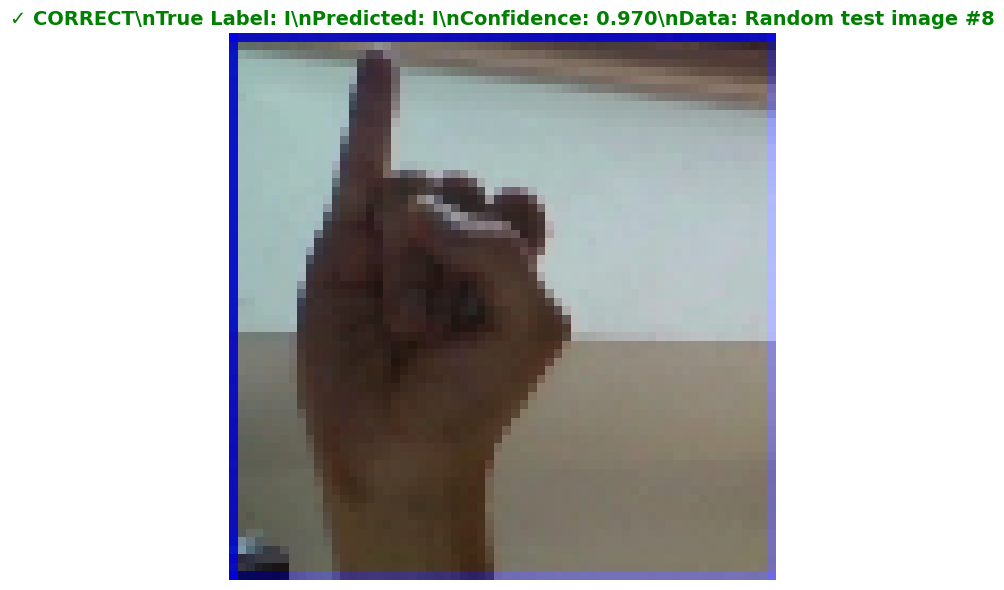

🎯 Random Prediction Results:
   Image Index: 8
   True Letter: I
   Predicted Letter: I
   Confidence: 0.970
   Result: ✓ CORRECT
------------------------------


In [14]:
# Function to predict a random image
def predict_random_image(X_data, y_true, model, class_names, data_type="test"):
    """
    Select a random image from the dataset and predict its ASL letter
    
    Args:
        X_data: Array of images
        y_true: True labels
        model: Trained model
        class_names: List of class names
        data_type: Type of data (for display purposes)
    
    Returns:
        predicted_letter: Predicted ASL letter
        true_letter: Actual ASL letter
        confidence: Prediction confidence
    """
    # Select a random image
    random_idx = np.random.randint(0, len(X_data))
    random_image = X_data[random_idx]
    true_label = y_true[random_idx]
    
    # Make prediction
    predicted_letter, confidence = predict_asl_from_array(random_image * 255, model, class_names)
    true_letter = class_names[true_label]
    
    # Display the image and prediction
    plt.figure(figsize=(8, 6))
    plt.imshow(random_image)
    
    # Color based on correct/incorrect prediction
    color = 'green' if predicted_letter == true_letter else 'red'
    status = "✓ CORRECT" if predicted_letter == true_letter else "✗ INCORRECT"
    
    plt.title(f'{status}\\n'
              f'True Label: {true_letter}\\n'
              f'Predicted: {predicted_letter}\\n'
              f'Confidence: {confidence:.3f}\\n'
              f'Data: Random {data_type} image #{random_idx}', 
              fontsize=14, color=color, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Print results
    print(f"🎯 Random Prediction Results:")
    print(f"   Image Index: {random_idx}")
    print(f"   True Letter: {true_letter}")
    print(f"   Predicted Letter: {predicted_letter}")
    print(f"   Confidence: {confidence:.3f}")
    print(f"   Result: {status}")
    
    return predicted_letter, true_letter, confidence

# Test the function with random test images
print("🎲 Predicting random test images:")
print("=" * 50)

# Predict 3 random test images
for i in range(3):
    print(f"\\n📸 Random Image #{i+1}:")
    predicted, true, conf = predict_random_image(X_test, test_true_classes, model, class_names, "test")
    print("-" * 30)

🚀 TESTING THE RANDOM PREDICTION FUNCTION
\n==================================================
\n1️⃣ Testing with VALIDATION set:
🎯 Predicting 2 random image(s) from val set:
\n📸 Random Prediction #1:


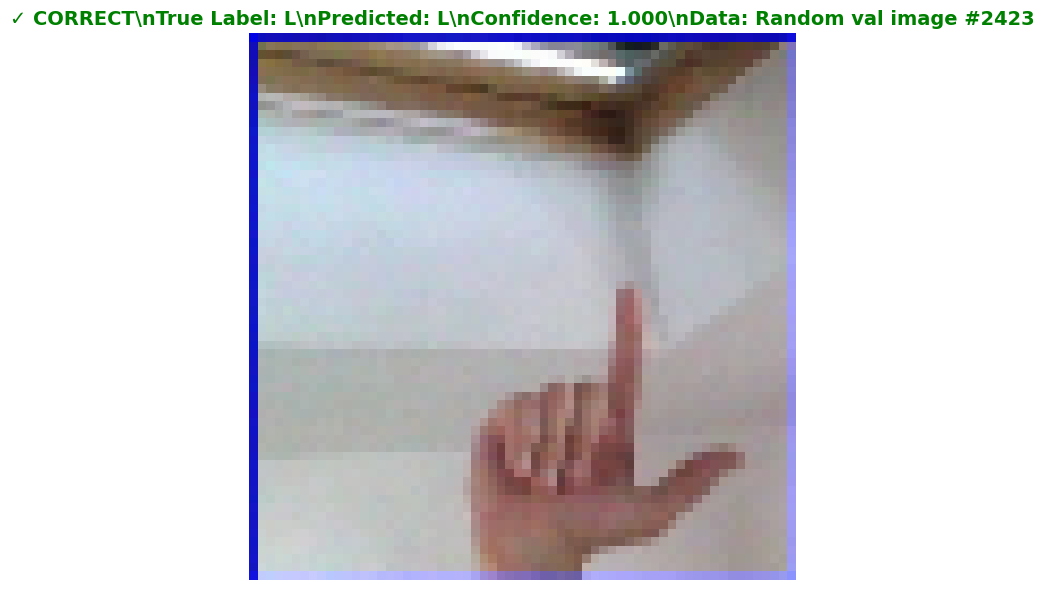

🎯 Random Prediction Results:
   Image Index: 2423
   True Letter: L
   Predicted Letter: L
   Confidence: 1.000
   Result: ✓ CORRECT
----------------------------------------
\n📸 Random Prediction #2:


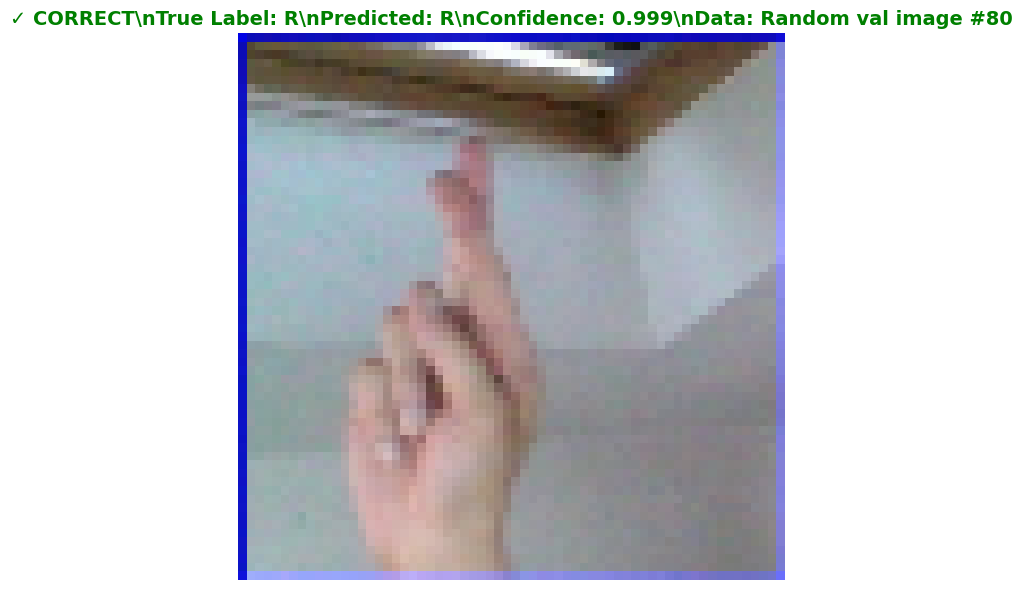

🎯 Random Prediction Results:
   Image Index: 80
   True Letter: R
   Predicted Letter: R
   Confidence: 0.999
   Result: ✓ CORRECT
\n📊 SUMMARY:
   Dataset: VAL
   Total Predictions: 2
   Correct Predictions: 2
   Accuracy: 100.0%
\n==================================================
\n2️⃣ Testing with TRAINING set:
🎯 Predicting 2 random image(s) from train set:
\n📸 Random Prediction #1:


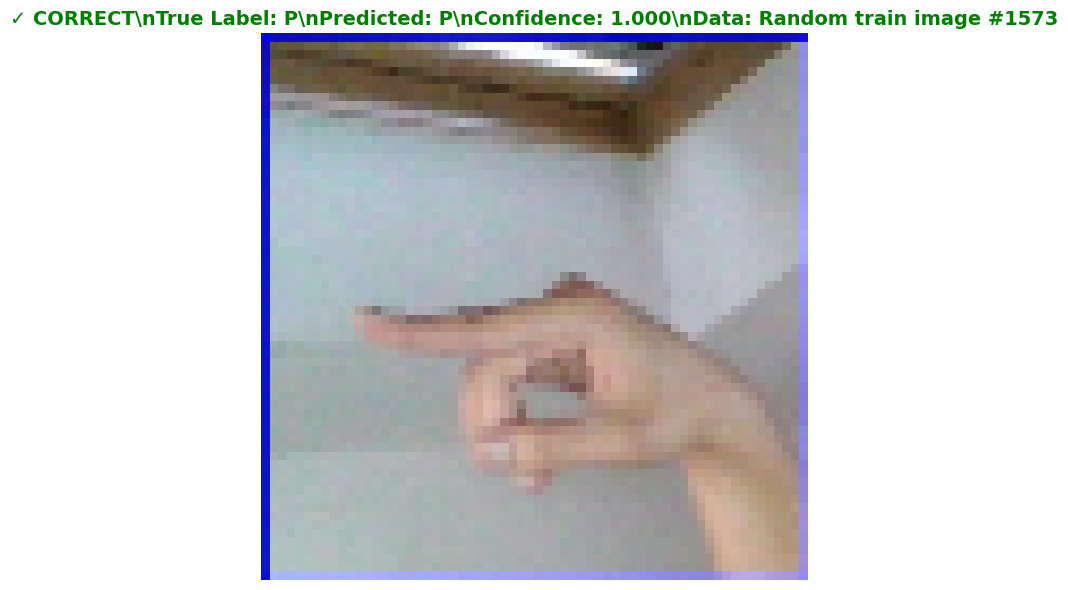

🎯 Random Prediction Results:
   Image Index: 1573
   True Letter: P
   Predicted Letter: P
   Confidence: 1.000
   Result: ✓ CORRECT
----------------------------------------
\n📸 Random Prediction #2:


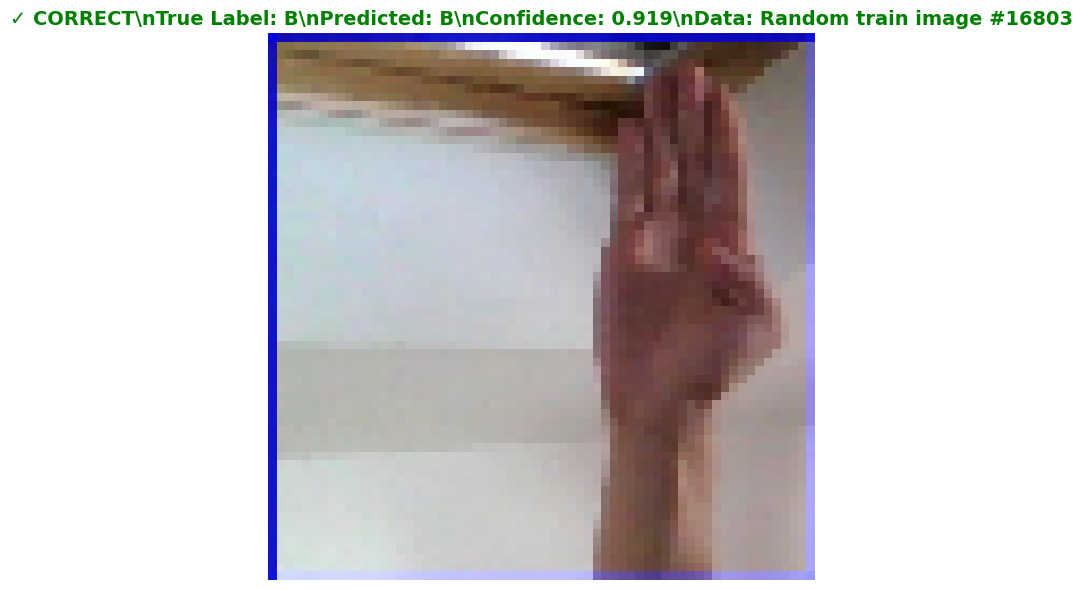

🎯 Random Prediction Results:
   Image Index: 16803
   True Letter: B
   Predicted Letter: B
   Confidence: 0.919
   Result: ✓ CORRECT
\n📊 SUMMARY:
   Dataset: TRAIN
   Total Predictions: 2
   Correct Predictions: 2
   Accuracy: 100.0%
\n==================================================
\n💡 TIP: You can call this function anytime with:
   predict_random_from_dataset('test', 5)    # 5 random test images
   predict_random_from_dataset('train', 3)   # 3 random training images
   predict_random_from_dataset('val', 1)     # 1 random validation image


In [15]:
# Interactive function to predict random images from different datasets
def predict_random_from_dataset(dataset_choice="test", num_predictions=1):
    """
    Predict random images from different datasets (test, training, or validation)
    
    Args:
        dataset_choice: "test", "train", or "val"
        num_predictions: Number of random predictions to make
    """
    print(f"🎯 Predicting {num_predictions} random image(s) from {dataset_choice} set:")
    print("=" * 60)
    
    # Select dataset based on choice
    if dataset_choice.lower() == "test":
        X_data = X_test
        y_data = test_true_classes
    elif dataset_choice.lower() == "train":
        X_data = X_train_split
        y_data = y_train_split
    elif dataset_choice.lower() == "val":
        X_data = X_val
        y_data = y_val
    else:
        print("❌ Invalid dataset choice. Use 'test', 'train', or 'val'")
        return
    
    correct_predictions = 0
    
    for i in range(num_predictions):
        print(f"\\n📸 Random Prediction #{i+1}:")
        predicted, true, conf = predict_random_image(X_data, y_data, model, class_names, dataset_choice)
        
        if predicted == true:
            correct_predictions += 1
        
        if i < num_predictions - 1:  # Don't print separator after last prediction
            print("-" * 40)
    
    # Summary
    accuracy = (correct_predictions / num_predictions) * 100
    print(f"\\n📊 SUMMARY:")
    print(f"   Dataset: {dataset_choice.upper()}")
    print(f"   Total Predictions: {num_predictions}")
    print(f"   Correct Predictions: {correct_predictions}")
    print(f"   Accuracy: {accuracy:.1f}%")

# Example usage - you can change these parameters
print("🚀 TESTING THE RANDOM PREDICTION FUNCTION")
print("\\n" + "="*50)

# Test with different datasets
print("\\n1️⃣ Testing with VALIDATION set:")
predict_random_from_dataset("val", 2)

print("\\n" + "="*50)
print("\\n2️⃣ Testing with TRAINING set:")
predict_random_from_dataset("train", 2)

print("\\n" + "="*50)
print("\\n💡 TIP: You can call this function anytime with:")
print("   predict_random_from_dataset('test', 5)    # 5 random test images")
print("   predict_random_from_dataset('train', 3)   # 3 random training images") 
print("   predict_random_from_dataset('val', 1)     # 1 random validation image")